In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
df = pd.read_csv('train.csv')

In [127]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First lets check for missing values

In [128]:
# sns.heatmap(df.isnull(),yticklabels=False,cmap='coolwarm')

In [129]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Some missing Age and a lot of missing Cabin data. Will have to determine the best action to filling in this data. 

For now begin by looking through the different columns

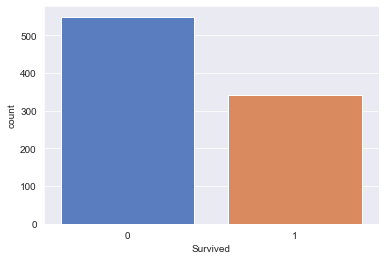

In [130]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.countplot(df['Survived']) #1 = Survived, 0 did not. 

So this is an example of a slightly inbalanced data set but not too bad.

Lets check the passenger class and see if that has a strong connection to survival.

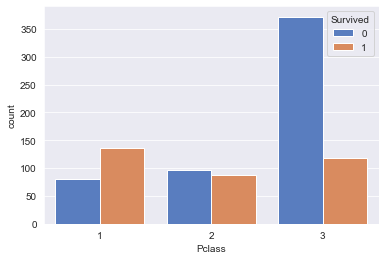

In [131]:
sns.countplot(x='Pclass',data=df,hue='Survived')

It is clear that a passenger's class has a stron effect on if they survived or not.

The name column will likely be dropped during feature engineering.

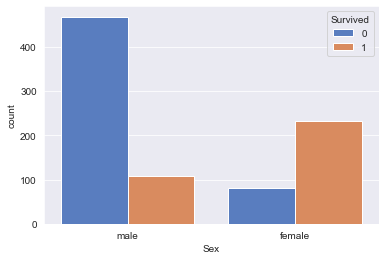

In [132]:
sns.countplot(x='Sex',data=df,hue='Survived')

Women were much more likely to survive compared to men. 

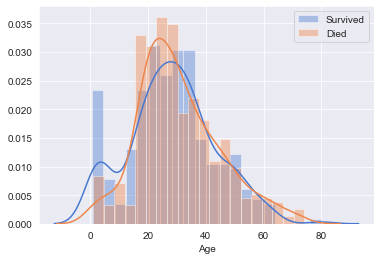

In [133]:
#To check if age had an effect of surival can break down the data into two sets and then plot historgrams. 
age_survived = df.loc[df['Survived']==1]['Age'].dropna()
age_died = df.loc[df['Survived']==0]['Age'].dropna()

sns.distplot(age_survived,bins=20,label='Survived')
sns.distplot(age_died,bins=20,label='Died')
plt.legend()

Shows that young children made up a larger percentage of the survivors. 

In [134]:
df['SibSp'].head()

0    1
1    1
2    0
3    1
4    0
Name: SibSp, dtype: int64

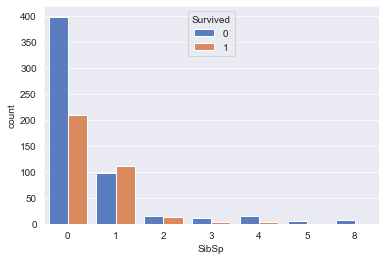

In [135]:
sns.countplot(x='SibSp',data=df,hue='Survived')

Actually shows that having a large family onboard often resulted in mostly deaths. 

In [136]:
df['Parch'].head()

0    0
1    0
2    0
3    0
4    0
Name: Parch, dtype: int64

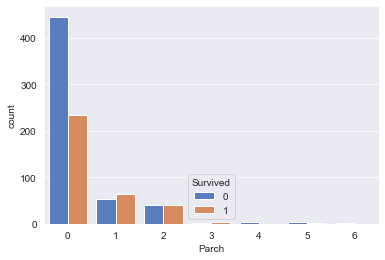

In [137]:
sns.countplot(x='Parch',data=df,hue='Survived')

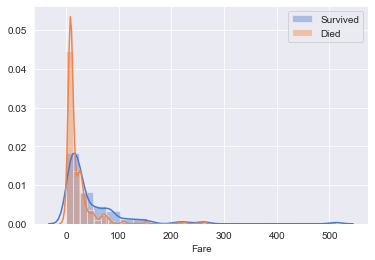

In [138]:
fare_survived = df.loc[df['Survived']==1]['Fare'].dropna()
fare_died = df.loc[df['Survived']==0]['Fare'].dropna()

sns.distplot(fare_survived,bins=20,label='Survived')
sns.distplot(fare_died,bins=20,label='Died')
plt.legend()

Lowest fares had a very high likelihood of dying. The higher the fare the better your chance at surviving. 

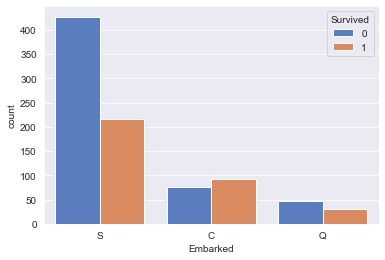

In [139]:
sns.countplot(x='Embarked',data=df,hue='Survived')

The port a passenger does seem to have some effect but maybe this is due to a higher percentage of high class passengers?

## Feature Engineering 

In [140]:
df_eng = df #Copy the dataframe
df_eng['Sex'].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [141]:
df.corr()['Age'].sort_values()

Pclass        -0.369226
SibSp         -0.308247
Parch         -0.189119
Survived      -0.077221
PassengerId    0.036847
Fare           0.096067
Age            1.000000
Name: Age, dtype: float64

In [142]:
age_lookup = df.groupby(['Sex','Pclass','SibSp']).mean()['Age']
def new_age(sex, pclass, sibsp, age):
    if np.isnan(age):
        return age_lookup[sex,pclass,sibsp]
    else:
        return age

df_eng['Age'] = df_eng.apply(lambda x: new_age(x['Sex'],x['Pclass'],x['SibSp'],x['Age']),axis=1)

Dealing with missing values

In [143]:
df_eng = df_eng.dropna(subset=['Embarked','Age'])

Dropping the cabin column do to the extremely large number of missing data points. Dropping Ticket and Name no useful info. 

In [144]:
df_eng.drop(['Cabin','Ticket','Name','PassengerId'],axis=1,inplace=True) 

In [145]:
#Make the dummy variables for Pclass, Sex, SibSp, Parch and Embarked

In [146]:
dummies = pd.get_dummies(df['Pclass'],drop_first=True,prefix='Pclass')
df_eng = pd.concat([df_eng,dummies],axis=1)
df_eng.drop('Pclass',axis=1,inplace=True)

dummies = pd.get_dummies(df['Sex'],drop_first=True,prefix='Sex')
df_eng = pd.concat([df_eng,dummies],axis=1)
df_eng.drop('Sex',axis=1,inplace=True)

dummies = pd.get_dummies(df['SibSp'],drop_first=True,prefix='SibSp')
df_eng = pd.concat([df_eng,dummies],axis=1)
df_eng.drop('SibSp',axis=1,inplace=True)

dummies = pd.get_dummies(df['Parch'],drop_first=True,prefix='Parch')
df_eng = pd.concat([df_eng,dummies],axis=1)
df_eng.drop('Parch',axis=1,inplace=True)


dummies = pd.get_dummies(df['Embarked'],drop_first=True,prefix='Embarked')
df_eng = pd.concat([df_eng,dummies],axis=1)
df_eng.drop('Embarked',axis=1,inplace=True)


df_eng.dropna(inplace=True)

In [147]:
df_eng.isnull().sum()

Survived      0
Age           0
Fare          0
Pclass_2      0
Pclass_3      0
Sex_male      0
SibSp_1       0
SibSp_2       0
SibSp_3       0
SibSp_4       0
SibSp_5       0
SibSp_8       0
Parch_1       0
Parch_2       0
Parch_3       0
Parch_4       0
Parch_5       0
Parch_6       0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [148]:
X = df_eng.drop('Survived',axis=1).values
y = df_eng['Survived'].values


## Model Making

Start with a neural network

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [150]:
#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25)

In [151]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [169]:
model = Sequential()

model.add(Dense(19, activation='relu'))
model.add(Dropout(.2))

model.add(Dense(9, activation='relu'))
model.add(Dropout(.2))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [170]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=55)

In [171]:
model.fit(x=X_train,y=y_train,epochs=600,validation_data=(X_test,y_test),callbacks=[early_stop])

Train on 661 samples, validate on 221 samples
Epoch 1/600
661/661 [==============================] - 0s 584us/sample - loss: 0.6795 - val_loss: 0.6398
Epoch 2/600
661/661 [==============================] - 0s 30us/sample - loss: 0.6557 - val_loss: 0.6189
Epoch 3/600
661/661 [==============================] - 0s 30us/sample - loss: 0.6289 - val_loss: 0.6037
Epoch 4/600
661/661 [==============================] - 0s 29us/sample - loss: 0.6216 - val_loss: 0.5895
Epoch 5/600
661/661 [==============================] - 0s 30us/sample - loss: 0.5909 - val_loss: 0.5763
Epoch 6/600
661/661 [==============================] - 0s 29us/sample - loss: 0.5972 - val_loss: 0.5663
Epoch 7/600
661/661 [==============================] - 0s 32us/sample - loss: 0.5682 - val_loss: 0.5538
Epoch 8/600
661/661 [==============================] - 0s 29us/sample - loss: 0.5617 - val_loss: 0.5444
Epoch 9/600
661/661 [==============================] - 0s 30us/sample - loss: 0.5546 - val_loss: 0.5335
Epoch 10/600
661/

661/661 [==============================] - 0s 30us/sample - loss: 0.4186 - val_loss: 0.4848
Epoch 79/600
661/661 [==============================] - 0s 29us/sample - loss: 0.4283 - val_loss: 0.4849
Epoch 80/600
661/661 [==============================] - 0s 29us/sample - loss: 0.4209 - val_loss: 0.4845
Epoch 81/600
661/661 [==============================] - 0s 30us/sample - loss: 0.4303 - val_loss: 0.4902
Epoch 82/600
661/661 [==============================] - 0s 29us/sample - loss: 0.4169 - val_loss: 0.4861
Epoch 83/600
661/661 [==============================] - 0s 29us/sample - loss: 0.4294 - val_loss: 0.4833
Epoch 84/600
661/661 [==============================] - 0s 30us/sample - loss: 0.4139 - val_loss: 0.4852
Epoch 85/600
661/661 [==============================] - 0s 30us/sample - loss: 0.4415 - val_loss: 0.4875
Epoch 86/600
661/661 [==============================] - 0s 29us/sample - loss: 0.4184 - val_loss: 0.4870
Epoch 87/600
661/661 [==============================] - 0s 30us/samp

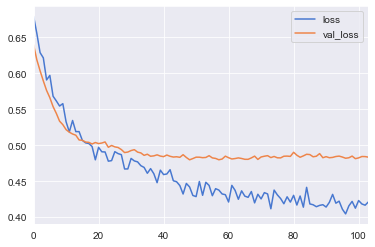

In [172]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [173]:
predictions = model.predict_classes(X_test)

In [174]:
from sklearn.metrics import classification_report, confusion_matrix

In [175]:
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       139
         1.0       0.76      0.57      0.65        82

    accuracy                           0.77       221
   macro avg       0.77      0.73      0.74       221
weighted avg       0.77      0.77      0.77       221



[[124  15]
 [ 35  47]]


With this approach it looks like we are miss labeling a lot of survivors as non survivors